# Effect of parameters on Scaling Efficiency

## Methodology

Using [Taguchi methods](https://eng.libretexts.org/Bookshelves/Industrial_and_Systems_Engineering/Book%3A_Chemical_Process_Dynamics_and_Controls_(Under_Construction)/14%3A_Design_of_Experiments/14.01%3A_Design_of_Experiments_via_Taguchi_Methods_-_Orthogonal_Arrays)

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib

In [2]:
system = 'cartesius'
df_interval = pd.read_parquet(f'data/mpi/{system}/{system}_interval.gzip')

In [3]:
# select configurations

def configurations_cartesius():
    '''
    Return a generator of all the configurations. Each configuration is a list of strings.
    '''
    network_backend = ['ib']
    profile_level = ['tau_exec']
    workers = [2, 8]
    neural_network = ['resnet50']
    data_loader = ['dali-gpu', 'dali-cpu-to-gpu']
    batch_size_per_gpu = [32, 64]
    grad_precision = ['fp16', 'fp32']
    compute_precision = ['fp32']
    
    def to_str(l):
        return [str(elem) for elem in l]

    confs = [
            network_backend,
            profile_level,
            to_str(workers),
            neural_network,
            data_loader,
            to_str(batch_size_per_gpu),
            grad_precision,
            compute_precision
            ]
    
    return itertools.product(*confs)

In [4]:
# select configurations

def configurations_lisa():
    '''
    Return a generator of all the configurations. Each configuration is a list of strings.
    '''
    network_backend = ['eth']
    profile_level = ['tau_exec']
    workers = [2, 4]
    neural_network = ['resnet50']
    data_loader = ['dali-gpu', 'dali-cpu-to-gpu']
    batch_size_per_gpu = [32, 64]
    grad_precision = ['fp16', 'fp32']
    compute_precision = ['fp32']
    
    def to_str(l):
        return [str(elem) for elem in l]

    confs = [
            network_backend,
            profile_level,
            to_str(workers),
            neural_network,
            data_loader,
            to_str(batch_size_per_gpu),
            grad_precision,
            compute_precision
            ]
    
    return itertools.product(*confs)

In [5]:
def median_duration_epoch(df, node, gpus_per_node, batch_size, init_time):
    '''
    Return the median duration of 1 epoch for the 10 runs of the experiment
    '''
    durations_epoch = []
                
    total_img_processed = node * int(gpus_per_node) * int(batch_size) * 50
    for run in range(10):

        duration = df[
            (df['gpus_per_node'] == int(gpus_per_node)) & 
            (df['nodes'] == node) & 
            (df['run'] == run)
        ]['inc_time']

        duration = np.max(duration) * 1E-6 # convert to seconds
        duration -= init_time # substract initialization time
        duration_epoch = duration * 1E6 / total_img_processed # 1 million images per epoch

        durations_epoch.append(duration_epoch)

    return np.array(durations_epoch)

In [6]:
def scaling_efficiencies(d):
    '''
    Return 2 lists:
    - all the numbers of GPUs used
    - the scaling efficiency for the corresponding number of GPUs
    '''
    efficiencies = {k:[] for k in d.keys()}
    for gpu, t in d.items():
        efficiencies[gpu] = d[16] / (gpu * t/16)*100
    return efficiencies

In [7]:
nodes = [8, 16, 32, 48] if system == 'cartesius' else [1, 4, 8]
data = []

confs = configurations_cartesius() if system == 'cartesius' else configurations_lisa()
for i, conf in enumerate(confs):
    network_backend, profile_level, workers, nn, data_loader, batch_size, grad, compute = conf

    mask_config = \
        (df_interval['network_backend'] == network_backend) & \
        (df_interval['profile_level'] == profile_level) & \
        (df_interval['workers'] == int(workers)) & \
        (df_interval['neural_network'] == nn) & \
        (df_interval['data_loader'] == data_loader) & \
        (df_interval['batch_size_per_gpu'] == int(batch_size)) & \
        (df_interval['grad_precision'] == grad) & \
        (df_interval['compute_precision'] == compute) & \
        (df_interval['function'] == '.tau application')
    
    df_config = df_interval[mask_config]
    
    d = {} # map number of GPUs to the duration of 1 epoch

    for node in nodes:
        gpus_per_node = 2 if system == 'cartesius' else 4 # experiments always use 2 GPUs per node
        d[node * gpus_per_node] = median_duration_epoch(df_config, node, gpus_per_node, batch_size, 0)
    
    efficiencies = scaling_efficiencies(d)
    for gpu, eff in efficiencies.items():
        data.append([gpu, network_backend, profile_level, workers, nn, data_loader, batch_size, grad, compute, eff])
    


In [8]:
df = pd.DataFrame(data, columns=['gpu', 'backend', 'profile', 'workers', 'nn', 'dataloader', 'batch_size', 'grad', 'compute', 'efficiency'])

In [9]:
df2 = df[['gpu', 'workers', 'dataloader', 'batch_size', 'grad', 'efficiency']]
df2[[f'T{n}' for n in range(1, 11)]] = pd.DataFrame(df2.efficiency.tolist())
df2 = df2[['gpu', 'workers', 'dataloader', 'batch_size', 'grad']+[f'T{n}' for n in range(1, 11)]]

/home/mat/Documents/courses/research/VU-RPML/env/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
df2['SN'] = -10*np.log10(sum(1/(df2[f'T{n}']**2)/10 for n in range(1, 11)))

In [11]:
d_gpu = df2.groupby('gpu')['SN'].mean().values.ptp()
d_workers = df2.groupby('workers')['SN'].mean().values.ptp()
d_dataloader = df2.groupby('dataloader')['SN'].mean().values.ptp()
d_batch = df2.groupby('batch_size')['SN'].mean().values.ptp()
d_grad = df2.groupby('grad')['SN'].mean().values.ptp()

In [12]:
df_params = pd.DataFrame([[d_gpu, d_workers, d_dataloader, d_batch, d_grad]], 
             columns=['gpu', 'workers', 'dataloader', 'batch size', 'grad'], 
             index=['$\Delta$ SN'])
df_params

,gpu,workers,dataloader,batch size,grad
$\Delta$ SN,0.39976,0.034262,0.02145,0.065573,0.066013


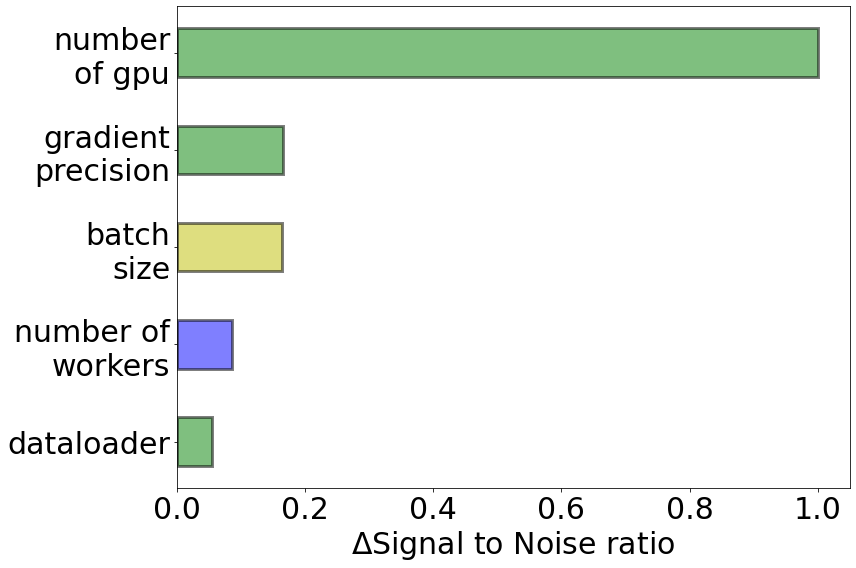

In [13]:
h = df_params.iloc[0].values
names = df_params.columns.values
h = h / np.max(h)
names[0] = 'number\nof gpu'
names[1] = 'number of\nworkers'
names[4] = 'gradient\nprecision'
names[3] = 'batch\nsize'
i = np.argsort(h)[::]

x = np.arange(1, len(h)+1)
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.barh(x, height=0.5, color=['g', 'b', 'y', 'g', 'g'], width=h[i], edgecolor='black', linewidth=3, alpha=0.5)
ax.tick_params(axis='both', labelsize=30)
ax.set_xlabel('$\Delta$Signal to Noise ratio', fontsize=30)
ax.set_yticks(x)
ax.set_yticklabels(names[i], fontsize=30)

plt.tight_layout()
# plt.savefig(f"images/{system}_parameters.png")